In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import networkx as nx
import pandas as pd
import re
import numpy as np
from typing import List, Dict, Tuple

class BuzzerDetector:
    def __init__(self):
        # Daftar manual buzzer yang sudah dikenal (bisa ditambah sesuai kebutuhan)
        self.manual_buzzer_list = [
            'buzzerpolitik1', 'akunbuzzer', 'politikbuzz',
            # Tambahkan username buzzer yang sudah dikenal
        ]

        # Stopwords bahasa Indonesia
        self.stopwords = {
            'yang', 'ini', 'itu', 'dan', 'di', 'ke', 'dari', 'untuk', 'dengan', 'pada',
            'adalah', 'akan', 'telah', 'sudah', 'ada', 'tidak', 'juga', 'atau', 'bisa',
            'dapat', 'harus', 'karena', 'saya', 'kamu', 'dia', 'kita', 'mereka', 'kami',
            'satu', 'dua', 'tiga', 'banyak', 'semua', 'beberapa', 'sebagai', 'seperti',
            'jika', 'kalau', 'ketika', 'saat', 'waktu', 'setelah', 'sebelum', 'hingga',
            'sampai', 'antara', 'dalam', 'luar', 'atas', 'bawah', 'depan', 'belakang',
            'kiri', 'kanan', 'tengah', 'mana', 'dimana', 'bagaimana', 'mengapa', 'kenapa',
            'siapa', 'apa', 'kapan', 'berapa', 'masing', 'setiap', 'tiap', 'per', 'nya',
            'mu', 'ku', 'lah', 'kah', 'pun', 'tah', 'dong', 'sih', 'ya', 'yah', 'deh',
            'lho', 'kok', 'wah', 'aduh', 'astaga', 'duh', 'ih', 'eh', 'oh', 'ah', 'hai',
            'halo', 'oke', 'ok', 'baik', 'bagus', 'buruk', 'jelek', 'cantik', 'ganteng',
            'kecil', 'besar', 'tinggi', 'rendah', 'panjang', 'pendek', 'lebar', 'sempit', 'aja'
        }

        # Kata kunci untuk deteksi buzzer di bio/description
        self.buzzer_keywords = [
            'buzzer', 'paid promote', 'endorse', 'marketing', 'influencer',
            'promosi', 'iklan', 'sponsor', 'jasa', 'followers', 'engagement'
        ]

        # Kata kunci untuk deteksi tweet promosi/iklan (diperluas dengan variasi)
        self.promo_keywords = [
            'promo', 'diskon', 'sale', 'beli', 'jual', 'order', 'wa ', 'whatsapp',
            'dm ', 'link bio', 'followers', 'likes', 'retweet', 'rt back',
            'follow back', 'followback', 'mutual', 'base', 'admin', 'dropship',
            'reseller', 'supplier', 'grosir', 'ecer', 'cod', 'transfer', 'bayar',
            'harga', 'murah', 'free', 'bonus', 'hadiah', 'voucher',
            'kupon', 'cashback', 'diskon', 'potongan', 'hemat', 'terbatas',
            'stok', 'ready', 'available', 'sold', 'habis', 'ludes'
        ]

        # Pattern regex untuk mendeteksi variasi ejaan promosi (leetspeak)
        self.promo_patterns = [
            r'pr[0o]m[0o]',  # promo, pr0mo, prom0, pr0m0
            r'd[i1]sc[0o]un[t7]',  # discount, d1scoun7, disc0unt
            r'[!@#$%]*promo[!@#$%]*',  # !promo!, @promo@, etc
            r'[!@#$%]*diskon[!@#$%]*',  # !diskon!, @diskon@, etc
            r'j[4a]w[4a]l',  # jawal (jual)
            r'b[3e]l[i1]',  # beli, b3li, bel1
            r'mur[4a]h',  # murah, mur4h
            r'c[0o]d',  # cod, c0d
            r'w[4a]',  # wa, w4
        ]

        # Kata kunci relevan untuk topik keracunan MBG (diperluas)
        self.relevant_keywords = [
            'mbg', 'keracunan', 'racun', 'makanan', 'minuman', 'jajanan',
            'kadaluarsa', 'expired', 'kesehatan', 'sakit', 'mual', 'muntah',
            'diare', 'pusing', 'keracunan makanan', 'food poisoning',
            'bpom', 'dinkes', 'puskesmas', 'rumah sakit', 'rs', 'dokter',
            'obat', 'antibiotik', 'infus', 'rawat', 'korban', 'pasien',
            'gejala', 'demam', 'lemas', 'dehidrasi', 'perut', 'lambung',
            'usus', 'pencernaan', 'bakteri', 'virus', 'kontaminasi',
            'higiene', 'sanitasi', 'kebersihan', 'cuci tangan'
        ]

    def remove_stopwords(self, text: str) -> str:
        """Menghapus stopwords dari teks"""
        if pd.isna(text) or not isinstance(text, str):
            return ""

        # Bersihkan teks dari karakter khusus dan angka berlebihan
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        text = re.sub(r'\d+', '', text)  # Hapus angka
        text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace

        # Split dan hapus stopwords
        words = text.split()
        filtered_words = [word for word in words if word not in self.stopwords and len(word) > 2]

        return ' '.join(filtered_words)

    def detect_promo_patterns(self, text: str) -> bool:
        """Deteksi pola promosi menggunakan regex untuk menangani variasi ejaan"""
        if pd.isna(text) or not isinstance(text, str):
            return False

        text_lower = text.lower()

        # Cek pattern regex
        for pattern in self.promo_patterns:
            if re.search(pattern, text_lower):
                return True

        # Cek keyword biasa
        for keyword in self.promo_keywords:
            if keyword in text_lower:
                return True

        return False

    def detect_buzzer_by_frequency(self, df_filtered: pd.DataFrame, min_tweets: int = 5, max_tweets_per_day: int = 15) -> List[str]:
        tweet_counts = df_filtered['username'].value_counts()

        # Filter akun dengan tweet setidaknya min_tweets
        high_frequency_users = tweet_counts[tweet_counts >= min_tweets].index.tolist()

        buzzer_candidates = []
        if 'created_at' in df_filtered.columns:
            # Pastikan kolom created_at sudah dalam tipe datetime
            if isinstance(df_filtered['created_at'].iloc[0], str):
                df_filtered['created_at'] = pd.to_datetime(df_filtered['created_at'], errors='coerce')

            for username in high_frequency_users:
                user_tweets = df_filtered[df_filtered['username'] == username]['created_at']
                user_tweets = user_tweets.dropna()

                if len(user_tweets) > 0:
                    # Hitung rata-rata tweet per hari
                    daily_counts = user_tweets.dt.date.value_counts()

                    # Jika ada hari dengan tweet > max_tweets_per_day, tandai sebagai buzzer
                    if (daily_counts > max_tweets_per_day).any():
                        buzzer_candidates.append(username)

                    # Tambahan: cek konsistensi posting (buzzer biasanya posting secara konsisten)
                    if len(daily_counts) > 1:
                        std_daily = daily_counts.std()
                        mean_daily = daily_counts.mean()
                        # Jika variasi posting sangat rendah (terlalu konsisten), mungkin bot
                        if std_daily < 1 and mean_daily > 5:
                            buzzer_candidates.append(username)

        return list(set(buzzer_candidates))

    def detect_buzzer_by_content(self, df_filtered: pd.DataFrame) -> List[str]:
        """Deteksi buzzer berdasarkan konten tweet (full_text) dengan pattern matching"""
        buzzer_candidates = []

        # Deteksi berdasarkan konten tweet yang bersifat promosi
        for _, row in df_filtered.iterrows():
            if self.detect_promo_patterns(row['full_text']):
                buzzer_candidates.append(row['username'])

        return list(set(buzzer_candidates))

    def detect_buzzer_by_network(self, df_filtered: pd.DataFrame, min_connections: int = 10) -> List[str]:
        """Deteksi buzzer berdasarkan pola jaringan (high centrality)"""
        buzzer_candidates = []

        # Buat graf untuk reply-network
        G = nx.DiGraph()
        for _, row in df_filtered.iterrows():
            if pd.notna(row['username']) and pd.notna(row['in_reply_to_screen_name']):
                G.add_edge(row['username'], row['in_reply_to_screen_name'])

        if len(G.nodes()) > min_connections:
            try:
                in_degree_centrality = nx.in_degree_centrality(G)
                out_degree_centrality = nx.out_degree_centrality(G)

                # Cari node dengan centrality di atas persentil ke-90 (lebih ketat dari 95)
                if len(in_degree_centrality) > 0:
                    thresh_in = np.percentile(list(in_degree_centrality.values()), 90)
                    thresh_out = np.percentile(list(out_degree_centrality.values()), 90)

                    high_in_degree = [node for node, cent in in_degree_centrality.items() if cent > thresh_in]
                    high_out_degree = [node for node, cent in out_degree_centrality.items() if cent > thresh_out]

                    buzzer_candidates.extend(high_in_degree + high_out_degree)
            except:
                # Jika terjadi error dalam perhitungan centrality
                pass

        return list(set(buzzer_candidates))

    def detect_irrelevant_content(self, df_filtered: pd.DataFrame) -> List[int]:
        """Deteksi tweet yang tidak relevan dengan topik keracunan MBG (dengan stopword removal)"""
        irrelevant_indices = []

        for idx, row in df_filtered.iterrows():
            # Terapkan stopword removal
            cleaned_text = self.remove_stopwords(row['full_text'])
            original_text = str(row['full_text']).lower()

            # Cek relevansi dengan kata kunci di teks yang sudah dibersihkan
            relevant_count = sum(1 for keyword in self.relevant_keywords if keyword in cleaned_text)

            # Cek juga di teks asli untuk keyword yang mungkin terpotong
            relevant_count_orig = sum(1 for keyword in self.relevant_keywords if keyword in original_text)

            total_relevant = max(relevant_count, relevant_count_orig)

            # Jika tidak ada kata kunci relevan, atau tweet sangat pendek
            if total_relevant == 0 or len(cleaned_text.split()) < 3:
                # Cek apakah ini tweet promosi/spam
                if self.detect_promo_patterns(original_text):
                    irrelevant_indices.append(idx)
                elif len(original_text.split()) < 5:  # Tweet terlalu pendek
                    irrelevant_indices.append(idx)
                elif total_relevant == 0:  # Tidak relevan sama sekali
                    irrelevant_indices.append(idx)

        return irrelevant_indices

    def clean_text_full(self, text: str) -> str:
        """
        Membersihkan teks secara menyeluruh:
        1. Ubah ke lowercase
        2. Hapus token 'RT ' di awal (jika tweet retweet)
        3. Hapus URL mulai dengan http:// atau https://
        4. Hapus mention @username
        5. Hapus hashtag #topik
        6. Hapus emoji/simbol Unicode (rentang umum)
        7. Hapus angka
        8. Hapus tanda baca / karakter non-alfabet
        9. Normalize spasi
        10. Remove stopwords
        """
        if pd.isna(text) or not isinstance(text, str):
            return ""

        # 1. lowercase
        t = text.lower()

        # 2. hapus "rt " di awal (retweet indicator)
        t = re.sub(r'^rt\s+', '', t)

        # 3. hapus URL
        t = re.sub(r'http\S+', ' ', t)       # http://… atau https://…
        t = re.sub(r'www\.\S+', ' ', t)      # www.domain…

        # 4. hapus mention
        t = re.sub(r'@\w+', ' ', t)

        # 5. hapus hashtag (tetap ambil kata di dalamnya, tapi di sini kita buang seluruh #tag)
        t = re.sub(r'#\w+', ' ', t)

        # 6. hapus emoji/simbol Unicode (rentang umum)
        #    Ini pola umum untuk sebagian emoji; mungkin tidak meng-cover semua,
        #    tapi cukup untuk kebanyakan emoji di rentang \U0001F600 - \U0001F6FF (emoticon, dingbats)
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticon
            "\U0001F300-\U0001F5FF"  # simbol & pictograph
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flag
            "\u2600-\u26FF"          # miscellaneous symbols
            "\u2700-\u27BF"          # dingbats
            "]+",
            flags=re.UNICODE
        )
        t = emoji_pattern.sub(' ', t)

        # 7. hapus angka
        t = re.sub(r'\d+', ' ', t)

        # 8. hapus tanda baca / non-alfabet
        #    Sisakan hanya huruf a–z dan spasi
        t = re.sub(r'[^a-z\s]', ' ', t)

        # 9. normalize whitespace (ganti multiple spasi → satu spasi, lalu strip)
        t = re.sub(r'\s+', ' ', t).strip()

        # 10. hapus stopwords
        t = self.remove_stopwords(t)

        return t

    def comprehensive_filter(self, df_filtered: pd.DataFrame, verbose: bool = True) -> Tuple[pd.DataFrame, Dict]:
        """Filtering komprehensif menggunakan semua metode"""
        return df_filtered['full_text'].apply(self.clean_text_full)

In [3]:
# 1. Membaca Dataset
df = pd.read_csv("KeracunanMBG.csv")
df.head()

print(df.describe(include='all'))  # Statistik numerik & kategorikal
print("\nJumlah Missing Values:")
print(df.isnull().sum())  # Cek data hilang

        conversation_id_str                      created_at  favorite_count  \
count          5.060000e+02                             506      506.000000   
unique                  NaN                             505             NaN   
top                     NaN  Mon May 12 00:30:25 +0000 2025             NaN   
freq                    NaN                               2             NaN   
mean           1.920475e+18                             NaN      159.171937   
std            7.510780e+15                             NaN     3187.178635   
min            1.757999e+18                             NaN        0.000000   
25%            1.920719e+18                             NaN        0.000000   
50%            1.921012e+18                             NaN        0.000000   
75%            1.921235e+18                             NaN        1.000000   
max            1.921740e+18                             NaN    71432.000000   

                                                ful

In [5]:
detector = BuzzerDetector()
df_filtered = df
df_filtered['cleaned_text'] = df_filtered['full_text'].apply(detector.clean_text_full)
df_filtered.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,cleaned_text
0,1921739694569877611,Mon May 12 01:30:22 +0000 2025,2,Tidak ada orang yang keracunan karena gambar m...,1921739694569877611,NaN,NaN,in,"Jakarta Selatan, DKI Jakarta",0,0,1,https://x.com/denismalhotra/status/19217396945...,478829168,denismalhotra,orang keracunan gambar meme tapi orang keracun...
1,1921369671279726677,Mon May 12 01:17:56 +0000 2025,0,@ARSIPAJA Setuju.... Begitu mau tawuran langsu...,1921736566495695282,NaN,ARSIPAJA,in,milky ways,0,0,0,https://x.com/LL__Cool__Z/status/1921736566495...,299777181,LL__Cool__Z,setuju begitu mau tawuran langsung kasih mbg a...
2,1921561545261359221,Mon May 12 01:15:24 +0000 2025,0,@CNNIndonesia Kasus keracunan sptnya akan terj...,1921735930580439329,NaN,CNNIndonesia,in,"Kota Jogja,DIY,Indonesia",0,0,0,https://x.com/herry_zudianto/status/1921735930...,170171658,herry_zudianto,kasus keracunan sptnya terjadi terus krn mbg d...
3,1921409302209912880,Mon May 12 01:07:34 +0000 2025,0,@Metro_TV MBG kalian aja bikin anak2 keracunan,1921733958712303737,NaN,Metro_TV,in,NaN,0,0,0,https://x.com/Sya_dayy/status/1921733958712303737,2320223304,Sya_dayy,mbg kalian bikin anak keracunan
4,1921561545261359221,Mon May 12 01:02:23 +0000 2025,0,@CNNIndonesia Potensi keracunan MBG dipastikan...,1921732653566545929,NaN,CNNIndonesia,in,Indonesia,0,0,0,https://x.com/sadili69920/status/1921732653566...,1848659256679313408,sadili69920,potensi keracunan mbg dipastikan terus berlanj...


In [6]:
print(df_filtered.describe(include='all'))  # Statistik numerik & kategorikal
print("\nJumlah Missing Values:")
print(df_filtered.isnull().sum())  # Cek data hilang

        conversation_id_str                      created_at  favorite_count  \
count          5.060000e+02                             506      506.000000   
unique                  NaN                             505             NaN   
top                     NaN  Mon May 12 00:30:25 +0000 2025             NaN   
freq                    NaN                               2             NaN   
mean           1.920475e+18                             NaN      159.171937   
std            7.510780e+15                             NaN     3187.178635   
min            1.757999e+18                             NaN        0.000000   
25%            1.920719e+18                             NaN        0.000000   
50%            1.921012e+18                             NaN        0.000000   
75%            1.921235e+18                             NaN        1.000000   
max            1.921740e+18                             NaN    71432.000000   

                                                ful

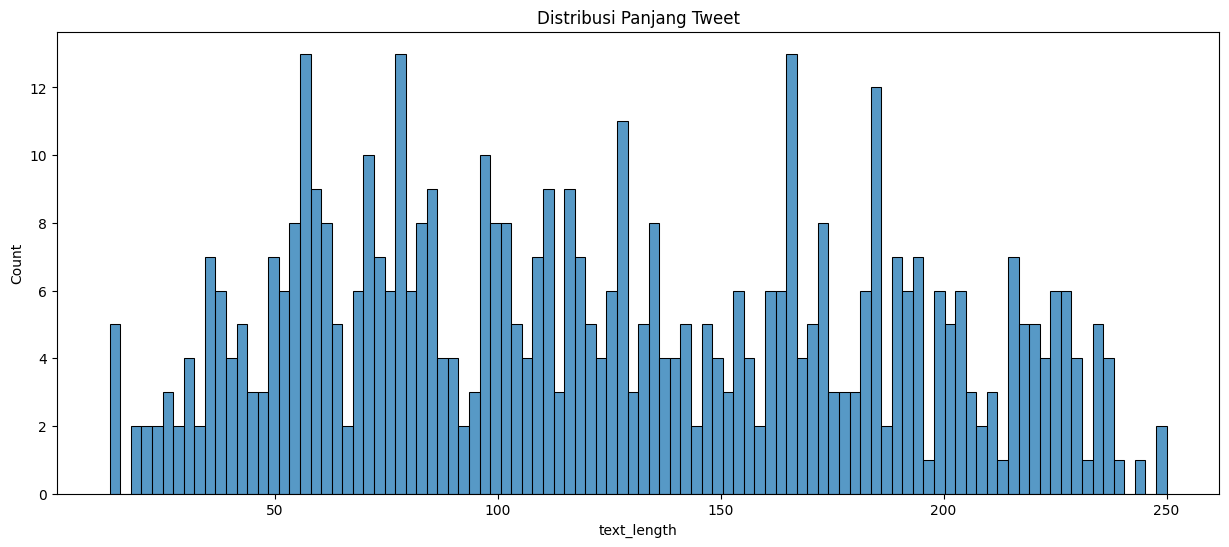

In [7]:
df_filtered['text_length'] = df_filtered['cleaned_text'].apply(len)
plt.figure(figsize=(15,6))
sns.histplot(df_filtered['text_length'], bins=100)
plt.title('Distribusi Panjang Tweet')
plt.show()

In [8]:
df_filtered[df_filtered['text_length'] < 20]

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,cleaned_text,text_length
13,1921616894412341709,Mon May 12 00:14:46 +0000 2025,0,@barcastuff_idn Keracunan MBG,1921720669412192753,NaN,barcastuff_idn,in,NaN,0,0,0,https://x.com/thetopofmylung/status/1921720669...,1091662945161859072,thetopofmylung,keracunan mbg,13
75,1921488531102290376,Sun May 11 08:59:46 +0000 2025,0,@bbJongseong keracunan mbg ya,1921490405616415030,NaN,bbJongseong,in,NaN,0,1,0,https://x.com/ggLeeIsa/status/1921490405616415030,2653253774,ggLeeIsa,keracunan mbg,13
113,1921426699201216970,Sun May 11 04:50:41 +0000 2025,0,@wventi Angka keracunan mbg,1921427721181110502,NaN,wventi,in,Produksi Media UI'24,0,1,0,https://x.com/muchidepok/status/19214277211811...,1793875807049515008,muchidepok,angka keracunan mbg,19
204,1921220372533260639,Sat May 10 15:23:42 +0000 2025,0,@SelebtwitMobil @MasMasBiassaa keracunan MBG kah?,1921224636903092694,NaN,SelebtwitMobil,in,NaN,0,0,0,https://x.com/apansa_kalengs/status/1921224636...,1037029910370430976,apansa_kalengs,keracunan mbg,13
246,1921155892373840383,Sat May 10 10:50:32 +0000 2025,0,Keracunan MBG???,1921155892373840383,NaN,NaN,in,"Kemayoran, Indonesia",0,0,0,https://x.com/Awwaliannoviar1/status/192115589...,1076356938223374336,Awwaliannoviar1,keracunan mbg,13
292,1921065210980229376,Sat May 10 04:50:12 +0000 2025,0,Anak TK keracunan MBG,1921065210980229376,NaN,NaN,in,RBW wooden corner,0,0,0,https://x.com/sonsonfisip/status/1921065210980...,1808495797581025280,sonsonfisip,anak keracunan mbg,18
322,1920828648342388929,Sat May 10 01:21:30 +0000 2025,0,@DCMKbase keracunan MBG,1921012689037353079,NaN,DCMKbase,in,Indonesia,0,0,0,https://x.com/lllllllita/status/19210126890373...,203116795,lllllllita,keracunan mbg,13


In [9]:
df_filtered['text_length'].describe()

count    506.000000
mean     124.588933
std       60.889650
min       13.000000
25%       74.000000
50%      118.000000
75%      174.750000
max      250.000000
Name: text_length, dtype: float64

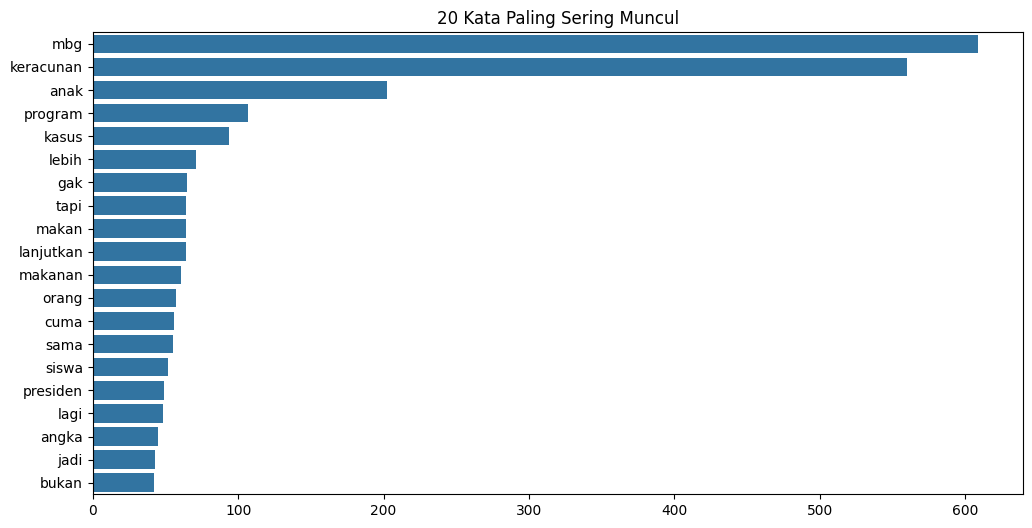

In [10]:
from collections import Counter

all_words = ' '.join(df_filtered['cleaned_text']).split()
word_freq = Counter(all_words).most_common(20)

plt.figure(figsize=(12,6))
sns.barplot(x=[w[1] for w in word_freq], y=[w[0] for w in word_freq])
plt.title('20 Kata Paling Sering Muncul')
plt.show()

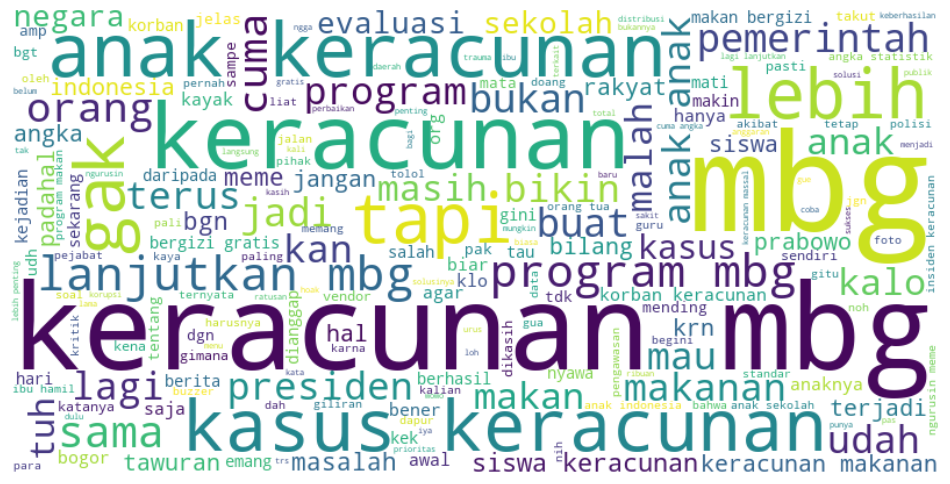

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_filtered['cleaned_text']))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_7588\1993675942.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_filtered['created_at'] = pd.to_datetime(df_filtered['created_at'])  # Konversi ke datetime


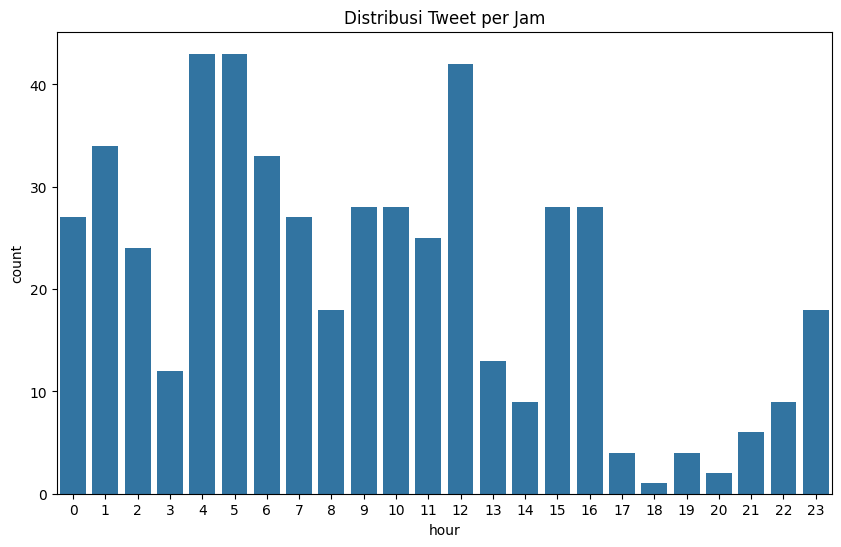

In [12]:
df_filtered['created_at'] = pd.to_datetime(df_filtered['created_at'])  # Konversi ke datetime
df_filtered['hour'] = df_filtered['created_at'].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(x='hour', data=df_filtered)
plt.title('Distribusi Tweet per Jam')
plt.show()

Text(0.5, 1.0, 'Top 10 Pengguna Paling Banyak Di Reply')

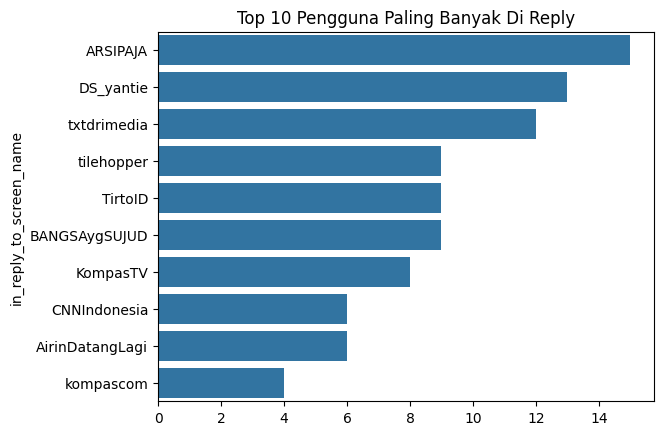

In [20]:
top_users = df_filtered['in_reply_to_screen_name'].value_counts().head(10)
sns.barplot(x=top_users.values, y=top_users.index)
plt.title('Top 10 Pengguna Paling Banyak Di Reply')

Text(0.5, 1.0, 'Top 10 Pengguna Paling Banyak Membuat Post')

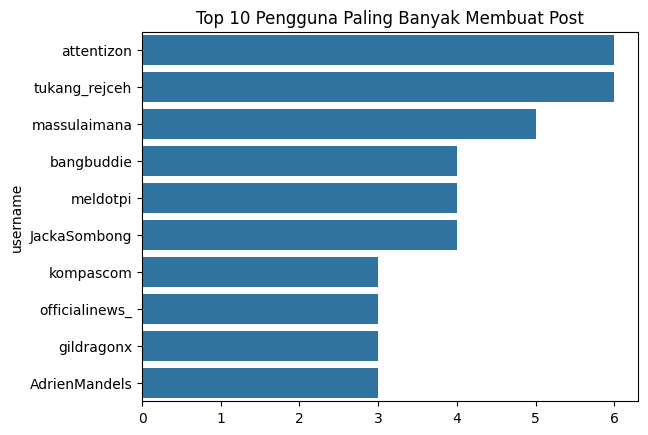

In [21]:
top_users = df_filtered['username'].value_counts().head(10)
sns.barplot(x=top_users.values, y=top_users.index)
plt.title('Top 10 Pengguna Paling Banyak Membuat Post')

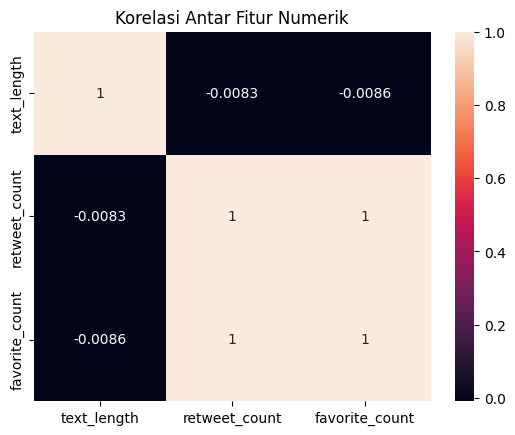

In [15]:
# Contoh untuk fitur numerik
numerical_features = ['text_length', 'retweet_count', 'favorite_count']
sns.heatmap(df_filtered[numerical_features].corr(), annot=True)
plt.title('Korelasi Antar Fitur Numerik')
plt.show()